In [1]:
#Setup
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
df1 = pd.read_csv('death-penalty-cases.csv')
df1['snippet'] = df1['snippet'].str.replace('hellip',' ').str.replace('\d+',' ')
state = df1['state']
Xraw = pd.read_pickle('X.pkl')
vocab = pd.read_pickle('vocab.pkl')



In [2]:
###
# OLS Regression
###

# list of words from our vectorizer
vocab = [w.replace(' ', '_') for w in vocab]
         
# convert frequency counts to dataframe
df4 = pd.DataFrame(Xraw.todense(),
                   columns=vocab)

# import statsmodels package for R-like regression formulas
import statsmodels.formula.api as smf

# add metadata
df4['Y'] = df1['citeCount'] # cites to this opinion
df4['courtfe'] = df1['court_id']   # court fixed effect
df4['yearfe'] = df1['year']        # year fixed effect

# empty lists for t-statistics and coefficients
tstats, betas = [], []

for xvar in vocab: # loop through the words in vocab
    if any([c.isdigit() for c in xvar]) or 'hellip' in xvar:
        tstats.append(0)
        betas.append(0)
        continue
    model = smf.ols('Y ~ %s' % xvar,data=df4)                
    result = model.fit() 
    tstats.append(result.tvalues[1])
    betas.append(result.params[1])
            
# save estimates
pd.to_pickle(tstats,'tstats.pkl')    
pd.to_pickle(betas,'betas.pkl')

# zip up words and t-statistics
stats = list(zip(vocab,tstats))
stats.sort(key = lambda x: x[1], reverse=True) # sort by second item (tstats)
stats[:10] + stats[-10:]

[('texas', 15.157060829813028),
 ('views', 14.162723136391653),
 ('penalty_quot', 13.98753979985411),
 ('death_penalty_quot', 13.882195791855542),
 ('death_penalty_law', 13.796881088968362),
 ('penalty_law', 13.786978075466088),
 ('vote_death_penalty', 13.200971205191417),
 ('vote_death', 13.198037293642521),
 ('vote', 12.90649508072616),
 ('views_death', 12.742941138262665),
 ('act', -12.866619826448563),
 ('aedpa', -12.908893663389017),
 ('antiterrorism', -13.023546041593066),
 ('antiterrorism_effective', -13.047299668279903),
 ('antiterrorism_effective_death', -13.047299668279903),
 ('death_penalty_act', -13.492546471662363),
 ('penalty_act', -13.492546471662363),
 ('effective', -13.662906539833903),
 ('effective_death', -14.225782953608297),
 ('effective_death_penalty', -14.225782953608297)]

In [5]:
# Make a small data set
from sklearn.feature_extraction.text import CountVectorizer
vectorizer500 = CountVectorizer(stop_words='english',
                             max_features=500)
X500 = vectorizer500.fit_transform(df1['snippet']).todense()
X500 = X500 / X500.sum(axis=1) # counts to frequencies
for i, word in enumerate(vectorizer500.get_feature_names()):
    column = X500[:,i]
    df1['x_'+word] = column

import numpy as np
df1['logcites'] = np.log(1+df1['citeCount'])

features = [x for x in df1.columns if x.startswith('x_')]
keepcols = ['logcites'] + features
df1 = df1[keepcols]

df1['any_cites'] = df1['logcites'] > 0
y = df1['any_cites']

# set up train/test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df1, test_size=0.2)
features = [x for x in df1.columns if x.startswith('x_')]

In [6]:
# Binary Classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=10) 
sgd_clf.fit(train[features], train['any_cites'])
sgd_clf.score(test[features],test['any_cites']) # accuracy on held-out data

0.7551427694197114

In [7]:
# compare to picking largest category
df1['any_cites'].mean()

0.7315994718580158

In [8]:
from multiprocessing import cpu_count
nthreads = cpu_count() - 1

# Form cross-validated prdictions for all data points
from sklearn.model_selection import cross_val_predict
df1['any_cites_sgd'] = cross_val_predict(sgd_clf,
                                         df1[features],
                                         df1['any_cites'],
                                         cv=3,
                                         n_jobs=nthreads)

In [9]:
# Construct confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(df1['any_cites'], df1['any_cites_sgd'])

array([[ 1318,  7423],
       [ 1626, 22200]])

In [10]:
# Precision and Recall
from sklearn.metrics import precision_score, recall_score
print('Precision:',precision_score(df1['any_cites'], df1['any_cites_sgd']))
print('Recall:',recall_score(df1['any_cites'], df1['any_cites_sgd']))

Precision: 0.7494176822063937
Recall: 0.9317552253840342


In [11]:
#F1 score
from sklearn.metrics import f1_score
f1_score(df1['any_cites'], df1['any_cites_sgd'])

0.8306984227955622

(array([  382.,   106.,    25.,   165.,   342.,   515.,  1963., 15049.,
        13883.,   137.]),
 array([-1.35464054, -1.05280852, -0.75097649, -0.44914447, -0.14731244,
         0.15451958,  0.45635161,  0.75818364,  1.06001566,  1.36184769,
         1.66367971]),
 <a list of 10 Patch objects>)

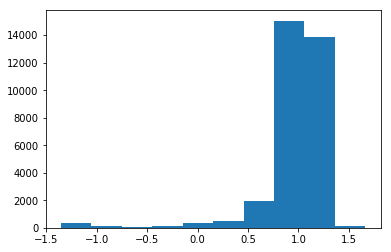

In [12]:
##############
# Precision/Recall Trade Off
##############
# scores used by SGDClassifier
y_scores = sgd_clf.decision_function(df1[features])
plt.hist(y_scores) # histogram of scores

In [13]:
# prediction using default threshold ... 
threshold = 0
(y_scores > threshold).mean()

0.975711609911874

In [14]:
# ... gives default model prediction
ypred = sgd_clf.predict(df1[features])
ypred.mean()

0.975711609911874

In [15]:
# increasing threshold means more zeros are predicted
threshold = 1
(y_scores > threshold).mean()

0.6110479933675192

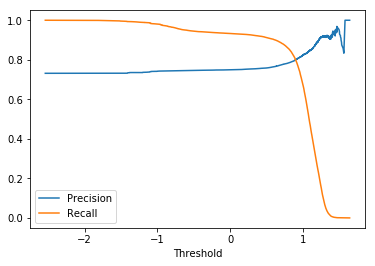

In [16]:
# Visualizing the precision/recall tradeoff
y_scores = cross_val_predict(sgd_clf,
                             df1[features],
                             df1['any_cites'],
                             cv=3,
                             method='decision_function',
                             n_jobs=3)

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(df1['any_cites'], y_scores)

import matplotlib.pyplot as plt
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel('Threshold')
plt.legend()

Text(0, 0.5, 'Precision')

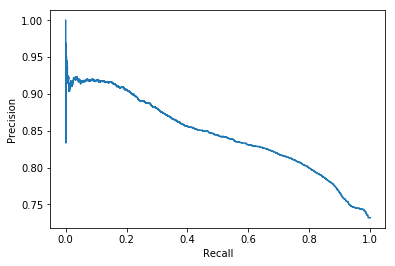

In [17]:
# Plot precision vs recall
plt.step(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')

In [18]:
# Assessing other scoring thresholds
ypred_lower = y_scores > -1
ypred_higher = y_scores > 1

print('Precision for Low Threshold:',precision_score(y, ypred_lower))
print('Precision for High Threshold:',precision_score(y, ypred_higher))
print('Recall for Low Threshold:',recall_score(y, ypred_lower))
print('Recall for High Threshold:',recall_score(y, ypred_higher))

Precision for Low Threshold: 0.742099412418612
Precision for High Threshold: 0.8228463269899734
Recall for Low Threshold: 0.9806513892386468
Recall for High Threshold: 0.675102828842441


Text(0, 0.5, 'True Positive Rate')

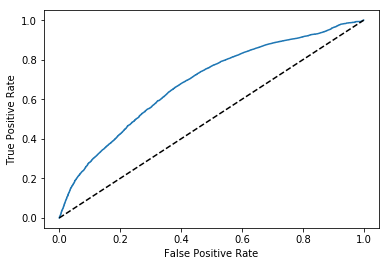

In [19]:
# ROC Curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y, y_scores)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [20]:
# AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y, y_scores)

0.6843684611845673

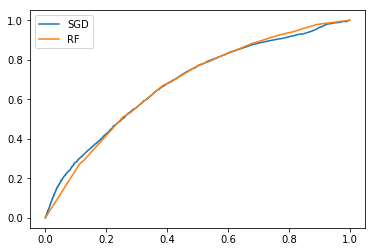

In [22]:
# Random Forests and predict_proba()
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
y_probas_rfc = cross_val_predict(rfc,
                                 X500,
                                 y,
                                 cv=3,
                                 method='predict_proba',
                                 n_jobs=3)

y_scores_rfc = y_probas_rfc[:,1]
fpr_rfc, tpr_rfc, thresholds_rfc = roc_curve(y,y_scores_rfc) 

# compare precision/recall tradeoff for SGD and RF classifiers
plt.plot(fpr, tpr, label="SGD")
plt.plot(fpr_rfc, tpr_rfc, label="RF")
plt.legend()

In [23]:
roc_auc_score(y,y_scores_rfc)

0.6824071700740255

In [24]:
###
# Multinomial CLassification
###
statepred = cross_val_predict(sgd_clf,
                              X500,
                              state,
                              cv=3)
print((statepred == state).mean())
list(zip(state[:8],statepred[:8]))

0.36134737617834006


[('NJ', 'PA'),
 ('FL', 'FL'),
 ('TX', 'TX'),
 ('NM', 'PA'),
 ('TX', 'GA'),
 ('AZ', 'NM'),
 ('NM', 'PA'),
 ('TN', 'MS')]

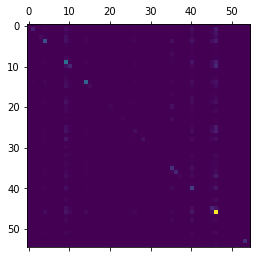

In [26]:
# Multi-class confusion matrix
conf_mx = confusion_matrix(state,statepred)
conf_mx
plt.matshow(conf_mx)
plt.show()

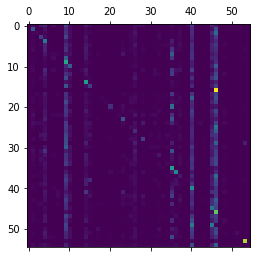

In [27]:
# normalize colors
conf_mx_norm = conf_mx / conf_mx.sum(axis=1, keepdims=True)
plt.matshow(conf_mx_norm)

In [36]:
# multi-class precision

# multi-class recall

# multi-class F1


In [28]:
###############
# Overfitting
##############
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.linear_model import LinearRegression

m = 100
X = 6 * np.random.rand(m,1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m,1)
y = y.ravel()

from sklearn.preprocessing import PolynomialFeatures
poly_2 = PolynomialFeatures(degree=2) # also adds interactions
X_poly_2 = poly_2.fit_transform(X)


poly_300 = PolynomialFeatures(degree=300) 
X_poly_300 = poly_300.fit_transform(X)


lin_reg = LinearRegression()
cross_val_score(lin_reg, X, y, cv=3, n_jobs=3).mean()

0.2710836645893286

In [29]:
cross_val_score(lin_reg, X_poly_2, y, cv=3, n_jobs=3).mean()

0.752545271800415

In [30]:
cross_val_score(lin_reg, X_poly_300, y, cv=3, n_jobs=3).mean()

-3.130595846893311e+20

In [31]:
# Lasso
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
cross_val_score(lasso_reg,X,y).mean()

0.27582155838453865

In [32]:
# Ridge
from sklearn.linear_model import Ridge, SGDRegressor
ridge_reg = Ridge(alpha=1)
cross_val_score(ridge_reg,X,y).mean()

0.272238681234141

In [33]:
###
# Elastic Net
###
from sklearn.linear_model import ElasticNetCV
enet_reg = ElasticNetCV(alphas=[.0001, .001, .01,.1,1], 
                        l1_ratio=[.0001, .001, .01,.1,.5,.9, .99, 1])
enet_reg.fit(X,y)
enet_reg.alpha_, enet_reg.l1_ratio_

(0.1, 0.0001)

In [34]:
cross_val_score(enet_reg,X,y).mean()

0.24429824915538

In [35]:
# Scaling with Sparsity
from sklearn.preprocessing import StandardScaler
sparse_scaler = StandardScaler(with_mean=False)
X_sparse = sparse_scaler.fit_transform(Xraw)

/home/elliott/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/elliott/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [36]:
X_sparse

<32567x472 sparse matrix of type '<class 'numpy.float64'>'
	with 460029 stored elements in Compressed Sparse Row format>

In [37]:
# Multinomial Logistic
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(C=1, # default L2 penalty # .01, .1, 1, 2, 10
                              class_weight='balanced')

scores = cross_val_score(logistic,
                         X_sparse[:1000],
                         state[:1000],
                         cv=3,
                         n_jobs=3)

scores.mean(), scores.std()

(0.4130743391509582, 0.007398675801953781)

## Dimension Reduction

In [38]:
#%% Principal Components
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X = Xraw.toarray()
Xpca = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.07618071, 0.05286707, 0.04029217])

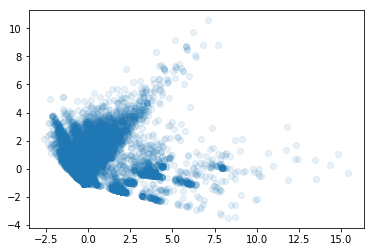

In [39]:
#%% PCA Viz
plt.scatter(Xpca[:,0],Xpca[:,1], alpha=.1)
plt.show()

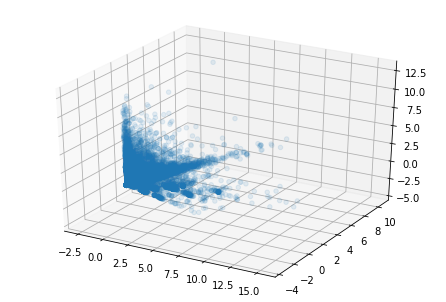

In [40]:
#%% PCA 3D Viz
from mpl_toolkits.mplot3d import Axes3D
Axes3D(plt.figure()).scatter(Xpca[:,0],Xpca[:,1], Xpca[:,2], alpha=.1)
plt.show()

In [41]:
#%% make components to explain 95% of variance
pca = PCA(n_components=.95)
X95 = pca.fit_transform(X)
pca.n_components_

253

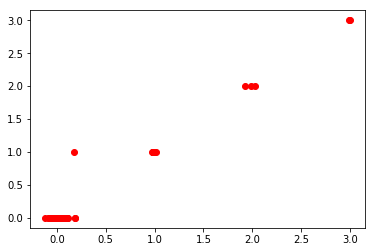

In [42]:
#%% PCA Inverse Transform
Xrestore = pca.inverse_transform(X95)
plt.plot(Xrestore[0],X[0],'ro')

In [43]:
#%% Incremental PCA
X_mm = np.memmap('X.pkl',shape=(32567, 525))

from sklearn.decomposition import IncrementalPCA
inc_pca = IncrementalPCA(n_components=100, batch_size=1000)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=1000, copy=True, n_components=100, whiten=False)

In [44]:
#%% PC Regression
lin_reg = LinearRegression()
Y = df1['logcites']
scores = cross_val_score(lin_reg,
                         X95[:,:10],
                         Y) 
scores.mean()

-2.4279886894264973

In [45]:
df1.head()

,logcites,x_ability,x_able,x_accordingly,x_accused,x_act,x_aedpa,x_affirm,x_affirmed,x_age,...,x_warranted,x_way,x_west,x_williams,x_witherspoon,x_year,x_years,x_yes,any_cites,any_cites_sgd
0,2.197225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True
1,6.315358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True
2,4.969813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True
4,4.043051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True


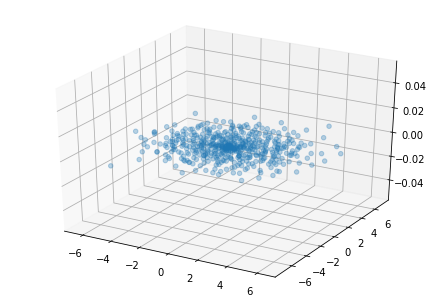

In [46]:
#%% MDS, Isomap, and T-SNE
from sklearn.manifold import MDS, Isomap, TSNE
mds = MDS(n_components=2)
Xmds = mds.fit_transform(X[:500,:200])
Axes3D(plt.figure()).scatter(Xmds[:,0],Xmds[:,1], alpha=.3)

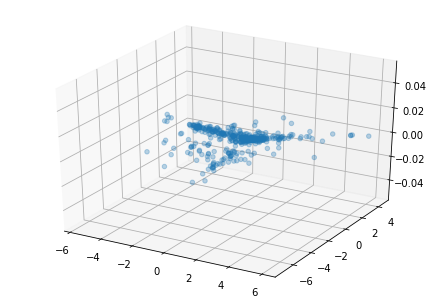

In [47]:
#%% Isomap
iso = Isomap(n_components=2)
Xiso = iso.fit_transform(X[:500,:200])
Axes3D(plt.figure()).scatter(Xiso[:,0],Xiso[:,1], alpha=.3)

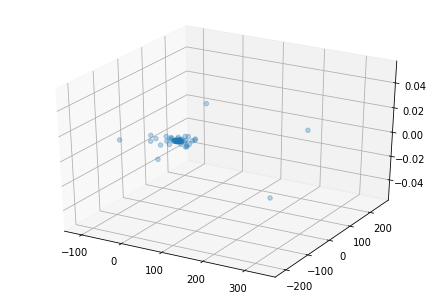

In [48]:
#%% t-SNE
tsne = TSNE(n_components=2, n_iter=250)
Xtsne = tsne.fit_transform(X[:500,:200])
Axes3D(plt.figure()).scatter(Xtsne[:,0],Xtsne[:,1], alpha=.3)

In [49]:
#%% Partial Least Squares
from sklearn.cross_decomposition import PLSRegression
pls = PLSRegression(n_components=10)
Xpls, Ypls = pls.fit_transform(X,Y)

In [51]:
#%% Visualization with labeling
#import ggplot as gg
#df1['x1'], df1['x2'] = Xpca[:,0],Xpca[:,1]
#chart = gg.ggplot( df1, gg.aes(x='x1', y='x2', color='has_cites') ) \
#                  + gg.geom_point(size=10, alpha=.8) 
#chart.show()

In [52]:
#%% PLS transformation
#df1['x1'], df1['x2'] = Xpls[:,0],Xpls[:,1]
#chart = gg.ggplot( df1, gg.aes(x='x1', y='x2', color='has_cites') ) \
#                  + gg.geom_point(size=10, alpha=.8) 
#chart.show()

In [53]:
#%% Feature Selection with Elastic Net
scaler = StandardScaler()
Xscale = scaler.fit_transform(X)
from sklearn.linear_model import ElasticNet
enet_reg = ElasticNet(alpha=.1, l1_ratio=.5)
enet_reg.fit(Xscale,Y)
nonzero = enet_reg.coef_ != 0
print(nonzero.sum(),'non-zero of',len(enet_reg.coef_),'coefficients.')
X_enet = X[:,nonzero]
cross_val_score(pls,X_enet,Y,n_jobs=-1).mean()

/home/elliott/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/elliott/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


94 non-zero of 472 coefficients.


-2.0954077881720807

In [54]:
#%% Univariate feature selection using chi2
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression, f_classif, mutual_info_classif
select = SelectKBest(chi2, k=10)
X_new = select.fit_transform(X, Y > 0 )
# top 10 features by chi-squared:
[vocab[i] for i in np.argsort(select.scores_)[:10]]

['does',
 'process',
 'automatic',
 'penalty_act_pub',
 'holding',
 'agreed',
 'act_pub',
 'shall',
 'penalty_state',
 'standard']

In [55]:
#%% top 10 features by  ANOVA F-value:
select = SelectKBest(f_classif, k=10)
select.fit(X, Y)
[vocab[i] for i in np.argsort(select.scores_)[:10]]

['aggravated',
 'florida_death',
 'florida_death_penalty',
 'necessary',
 'prison',
 'habeas',
 'intent_seek',
 'intent_seek_death',
 'entered',
 'commonwealth']

In [56]:
#%% top 10 features by linear regression
select = SelectKBest(f_regression, k=10)
select.fit(X, Y)
[vocab[i] for i in np.argsort(select.scores_)[:10]]

['counsel',
 'court_sentenced',
 'motion',
 'pursuant',
 'standard',
 'order',
 'testified',
 'attorney',
 'death_penalty_sentence',
 'penalty_sentence']

In [57]:
#%% top 10 features by mutual information (classification)
select = SelectKBest(mutual_info_classif, k=10)
select.fit(X[:1000], Y[:1000] > 0) # run on subset
[vocab[i] for i in np.argsort(select.scores_)[:10]]

['accordingly',
 'opposed_death',
 'opposed',
 'opinion',
 'offense',
 'objections',
 'notice_intent',
 'notice',
 'order',
 'non_death_penalty']

## Ensemble Learning

In [58]:
Y = df1['logcites'] > 0

# Bagging classifier

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
        DecisionTreeClassifier(), n_estimators=50,
        max_samples=100, bootstrap=True, n_jobs=-1
    )

cross_val_score(bag_clf, X, Y).mean()

0.7230924240742481

In [59]:
# random forest
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, 
                                 max_leaf_nodes=16, 
                                 n_jobs=-1)
y_pred_rf = cross_val_predict(rnd_clf, X, Y)                              
confusion_matrix(Y,y_pred_rf)

array([[ 1690,  7051],
       [ 1841, 21985]])

In [60]:
rnd_clf.fit(X,Y)
feature_importances = rnd_clf.feature_importances_
sorted(zip(feature_importances, vocab),reverse=True)[:20]

[(0.05526929359073517, 'quot'),
 (0.0506830963219971, 'felony_non'),
 (0.049677546412037525, 'published'),
 (0.04640746598085661, 'felony_non_death'),
 (0.043315269782835245, 'death_penalty_published'),
 (0.04050892197426219, 'non_death_penalty'),
 (0.04013374935500228, 'non_death'),
 (0.039662787059864875, 'penalty_published'),
 (0.03374025518840539, 'non'),
 (0.027842811421367897, 'state_did'),
 (0.026044894811812068, 'penalty_sanctions'),
 (0.02586623525467934, 'state_did_seek'),
 (0.0248293305757757, 'did_seek_death'),
 (0.024019550548382278, 'death_penalty_sanctions'),
 (0.023922601942533588, 'did_seek'),
 (0.02298354256235177, 'felony'),
 (0.02145879741877367, 'sanctions'),
 (0.020519309381116648, 'imposed'),
 (0.019712512851758804, 'jury'),
 (0.017752590443719216, 'sanction')]

In [62]:
# XGBoost
from xgboost import XGBClassifier, XGBRegressor
dfX = pd.DataFrame(X,columns=vocab)
xgb_clf = XGBClassifier()
cross_val_score(xgb_clf, dfX, Y).mean()

0.735343835315594

In [63]:
xgb_reg = XGBRegressor(feature_names=vocab)
xgb_reg.fit(dfX,Y)
sorted(zip(xgb_reg.feature_importances_, vocab),reverse=True)[:10]

[(0.08175182, 'quot'),
 (0.026277373, 'criminal'),
 (0.023357663, 'texas'),
 (0.023357663, 'felony'),
 (0.018978102, 'case'),
 (0.017518248, 'seek'),
 (0.017518248, 'sanctions'),
 (0.017518248, 'petitioner'),
 (0.016058395, 'state'),
 (0.016058395, 'non_death')]

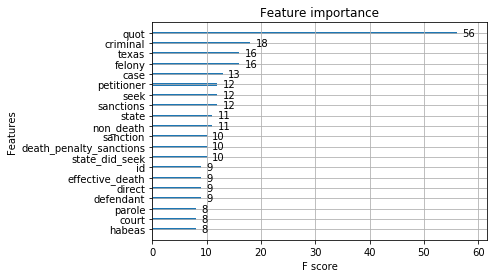

In [64]:
from xgboost import plot_importance
plot_importance(xgb_reg, max_num_features=20)